# Typed Memoryviews

In [1]:
%load_ext cython

In [2]:
%%cython
from cython.view cimport array as cvarray
import numpy as np

# Memoryview on a NumPy array
narr = np.arange(27, dtype=np.dtype("i")).reshape((3, 3, 3))
cdef int [:, :, :] narr_view = narr
print(narr)
print(narr_view)
print(narr_view.base)

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]]]
<MemoryView of 'ndarray' object>
[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]]]


In [3]:
%%cython
#@cython.boundscheck(False)  # Deactivate bounds checking
#@cython.wraparound(False)   # Deactivate negative indexing.
# cython: nonecheck=True
# cython: boundscheck=False
# cython: wraparound=False
from cython.view cimport array as cvarray
import numpy as np

# Memoryview on a NumPy array
narr = np.arange(27, dtype=np.dtype("i")).reshape((3, 3, 3))
cdef int [:, :, :] narr_view = narr

# Memoryview on a C array
cdef int carr[3][3][3]
cdef int [:, :, :] carr_view = carr

# Memoryview on a Cython array
cyarr = cvarray(shape=(3, 3, 3), itemsize=sizeof(int), format="i")
cdef int [:, :, :] cyarr_view = cyarr

# Show the sum of all the arrays before altering it
print("NumPy sum of the NumPy array before assignments: %s" % narr.sum())

# We can copy the values from one memoryview into another using a single
# statement, by either indexing with ... or (NumPy-style) with a colon.
carr_view[...] = narr_view
cyarr_view[:] = narr_view
# NumPy-style syntax for assigning a single value to all elements.
narr_view[:, :, :] = 3

# Just to distinguish the arrays
carr_view[0, 0, 0] = 100
cyarr_view[0, 0, 0] = 1000

# Assigning into the memoryview on the NumPy array alters the latter
print("NumPy sum of NumPy array after assignments: %s" % narr.sum())

# A function using a memoryview does not usually need the GIL

cpdef int sum3d(int[:, :, :] arr) nogil:
    cdef size_t i, j, k
    cdef int total = 0
    I = arr.shape[0]
    J = arr.shape[1]
    K = arr.shape[2]
    for i in range(I):
        for j in range(J):
            for k in range(K):
                total += arr[i, j, k]
    return total

# A function accepting a memoryview knows how to use a NumPy array,
# a C array, a Cython array...
print("Memoryview sum of NumPy array is %s" % sum3d(narr))
print("Memoryview sum of C array is %s" % sum3d(carr))
print("Memoryview sum of Cython array is %s" % sum3d(cyarr))
# ... and of course, a memoryview.
print("Memoryview sum of C memoryview is %s" % sum3d(carr_view))

NumPy sum of the NumPy array before assignments: 351
NumPy sum of NumPy array after assignments: 81
Memoryview sum of NumPy array is 81
Memoryview sum of C array is 451
Memoryview sum of Cython array is 1351
Memoryview sum of C memoryview is 451


### Declaring Contiguous arrays

For extra speed gains, if you know that the NumPy arrays you are providing are contiguous in memory, you can declare the memoryview as contiguous.

We give an example on an array that has 3 dimensions. If you want to give Cython the information that the data is C-contiguous you have to declare the memoryview like this:

In [4]:
%%cython
import numpy as np
# This array is C contiguous
c_contig = np.arange(24).reshape((2,3,4)) #by default, arange return int64 data type
cdef long[:, :, ::1] c_contiguous = c_contig


arr = np.zeros((5, 5), dtype=np.int32)
#arr = np.arange(16,dtype=np.int32).reshape((4, 4))
cdef int[:,::1] c_contiguous2 = arr
print(c_contiguous2)
print(np.asarray(c_contiguous2))
print(c_contiguous2.base)

<MemoryView of 'ndarray' object>
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


### Now wrapping a C implementation.

First we have a header file c_func_file.h

In [6]:
!mkdir mvwrap

In [7]:
cd mvwrap

/Users/asenjo/Documents/docencia/MUII/arrayviews/mvwrap


In [8]:
%%writefile c_func_file.h
#ifndef C_FUNC_FILE_H
#define C_FUNC_FILE_H

void multiply_by_10_in_C(double arr[], unsigned int n);

#endif

Writing c_func_file.h


Now the C implementation in the c_func_file.c file

In [9]:
%%writefile c_func_file.c
#include "c_func_file.h"

void multiply_by_10_in_C(double arr[], unsigned int n)
{
    unsigned int i;
    for (i = 0; i < n; i++) {
        arr[i] *= 10;
    }
}

Writing c_func_file.c


Next, we need a Python function multiply_by_10(arr) wrapping the C function multiply_by_10_in_C(arr,n):

In [10]:
%%writefile multby10.pyx
cdef extern from "c_func_file.h":
    void multiply_by_10_in_C(double *, unsigned int)

import numpy as np

def multiply_by_10(arr): # 'arr' is a one-dimensional numpy array
    ''' Multiply each element by 10.'''
    if not arr.flags['C_CONTIGUOUS']:
        print('Ooopss... we had to make a copy')
        arr = np.ascontiguousarray(arr) # Makes a contiguous copy of the numpy array.

    cdef double[::1] arr_memview = arr

    multiply_by_10_in_C(&arr_memview[0], arr_memview.shape[0])

    return arr

Writing multby10.pyx


Several things to note:

1. `::1` requests a C contiguous view, and fails if the buffer is not C contiguous.
2. `&arr_memview[0]` can be understood as ‘the address of the first element of the memoryview’. For contiguous arrays, this is equivalent to the start address of the flat memory buffer.
3. `arr_memview.shape[0]` could have been replaced by `arr_memview.size`, `arr.shape[0]` or `arr.size`. But `arr_memview.shape[0]` is more efficient because it doesn’t require any Python interaction.
4. `multiply_by_10` will perform computation **in-place** if the array passed is contiguous, and will return a new numpy array if arr is not contiguous.
5. If you are using Python arrays instead of numpy arrays, you don’t need to check if the data is stored contiguously as this is always the case. See Working with Python arrays.

This way, you can call the C function similar to a normal Python function, and leave all the memory management and cleanup to NumPy arrays and Python’s object handling.

Finally we need a python script to build everything:

In [11]:
%%writefile setup_wrap.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

# First create an Extension object with the appropriate name and sources
ext = Extension(name="MultBy10", sources=["c_func_file.c", "multby10.pyx"])

# Use cythonize on the extension object.
setup(ext_modules=cythonize(ext))

Writing setup_wrap.py


We are all set to execute this command:

In [12]:
!python setup_wrap.py build_ext --inplace

Compiling multby10.pyx because it changed.
[1/1] Cythonizing multby10.pyx
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/asenjo/Documents/docencia/MUII/arrayviews/mvwrap/multby10.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'MultBy10' extension
creating build
creating build/temp.macosx-10.7-x86_64-3.6
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/anaconda3/include -arch x86_64 -I/anaconda3/include -arch x86_64 -I/anaconda3/include/python3.6m -c multby10.c -o build/temp.macosx-10.7-x86_64-3.6/multby10.o
multby10.c:18083:26: warning: code will never be executed [-Wunreachable-code]
                module = PyImport_ImportModuleLevelObject(
                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 warning generated.
gcc -Wno-unused-resul

In [13]:
!ls

MultBy10.cpython-36m-darwin.so multby10.c
build                          multby10.pyx
c_func_file.c                  setup_wrap.py
c_func_file.h


And now let's use our new fib implementation:

In [14]:
from MultBy10 import multiply_by_10
help(multiply_by_10)

Help on built-in function multiply_by_10 in module MultBy10:

multiply_by_10(...)
    Multiply each element by 10.



In [15]:
a = np.ones(5, dtype=np.double)
print(multiply_by_10(a))

b = np.ones(10, dtype=np.double)
b = b[::2]  # b is not contiguous.

print(multiply_by_10(b))  # but our function still works as expected.

[10. 10. 10. 10. 10.]
Ooopss... we had to make a copy
[10. 10. 10. 10. 10.]


#### More information
See the documentation of:
* [Typed Memoryviews](http://docs.cython.org/en/latest/src/userguide/memoryviews.html)
* [Cython for NumPy users](http://docs.cython.org/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial)

# Back to Mandelbrot computation

In [16]:
size = 400
iterations = 100

In [18]:
%%cython -a
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [19]:
s = (size, size)

In [20]:
j=2
i=3
c = -2 + 3/size*j + 1j*(1.5-3/size*i)
c

(-1.985+1.4775j)

In [21]:
%%timeit -n1 -r1 
m = np.zeros(s, dtype=np.int32)
mandelbrot_cython(m, size, iterations)

6.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
%%cython -a
import numpy as np

def mandelbrot_cython(int[:,::1] m, # NOTE the memoryview!!
                      int size,
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [23]:
%%timeit -n10 -r10 
m = np.zeros(s, dtype=np.int32)
mandelbrot_cython(m, size, iterations)

14.7 ms ± 408 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


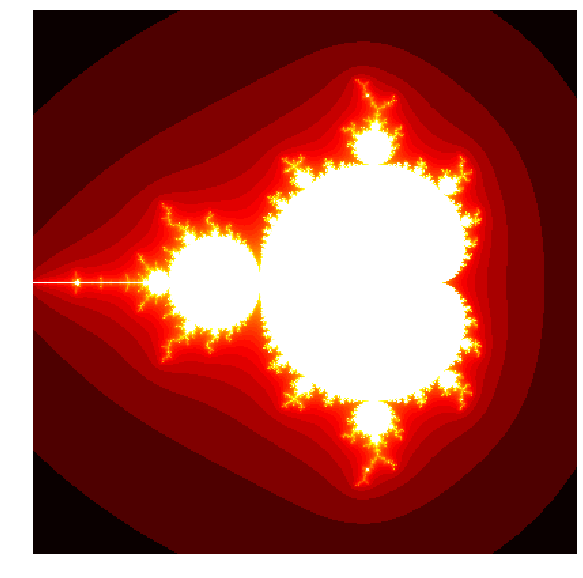

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
m = np.zeros(s, dtype=np.int32)
mandelbrot_cython(m, size, iterations)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()

### Now in C++

In [25]:
cd ..

/Users/asenjo/Documents/docencia/MUII/arrayviews


In [26]:
!mkdir mandelC

In [27]:
cd mandelC

/Users/asenjo/Documents/docencia/MUII/arrayviews/mandelC


In [28]:
%%writefile mandelbrot.cpp
#include <complex>
#include <chrono>
#include <cstdlib>
#include <iostream>

// Use an alias to simplify the use of complex type
using Complex = std::complex<double>;

void mandelbrot(int* m, int size, int iterations) {
  Complex z,c;
  for (int i=0; i< size; i++){
    for (int j=0; j< size; j++){
      c= {-2 + 3./size * j, 1.5-3./size*i};
      z=0;
      int iter = 0;
      while ((z.real()*z.real() + z.imag()*z.imag()) <= 100.0 && iter < iterations)
      {
        z = z*z + c;
        iter++;
      }
      m[i*size + j] = iter-1;
    }
  }
}

int main(){
  int size=400;
  int iters = 100;
  int* m = new int[size*size];
  const auto start = std::chrono::high_resolution_clock::now();
  for(int i=0; i<100; i++){
    mandelbrot(m,size,iters);
  }
  const auto end = std::chrono::high_resolution_clock::now();
  const auto duration =std::chrono::duration<double,std::milli>(end - start).count() / 100;
  std::cout << "Execution time: " << duration << " ms." << std::endl;
  // for(int i=0; i<400*400; i++){
  //   std::cout << m[i] << "  ";
  // }
  std::cout << m[12300] << std::endl;
  delete [] m;
  return 0;
}

Writing mandelbrot.cpp


In [29]:
!g++ -o mandel mandelbrot.cpp -std=c++11 -O3

In [30]:
!./mandel

Execution time: 38.6193 ms.
3


Too bad!!! 
Instead of using std::complex, let's build our own Complex class:

In [31]:
%%writefile mandelbrot2.cpp
#include <complex>
#include <chrono>
#include <cstdlib>
#include <iostream>

struct Complex {
  double real, imag;
  double abs(){
     return real * real + imag * imag; //really the square of the absolute value
  }
  void mandelop(Complex &c){
     double r = real * real - imag * imag + c.real;
     double i = 2 * real * imag + c.imag;
     real=r;
     imag=i;
  }
};

void mandelbrot(int* m, int size, int iterations) {
  Complex z,c;
  for (int i=0; i< size; i++){
    int isize=i*size;
    for (int j=0; j< size; j++){
      c = {-2 + 3./size * j, 1.5-3./size*i};
      z = {0,0};
      for (int iter = 0; iter < iterations; iter++){
        if (z.abs() <= 100.0){
          z.mandelop(c);
          m[isize + j] = iter;
        }
        else break;
      }
    }
  }
}

int main(){
  int size=400;
  int iters = 100;
  int* m = new int[size*size];
  const auto start = std::chrono::high_resolution_clock::now();
  for(int i=0; i<100; i++){
    mandelbrot(m,size,iters);
  }
  const auto end = std::chrono::high_resolution_clock::now();
  const auto duration =std::chrono::duration<double,std::milli>(end - start).count() / 100;
  std::cout << "Execution time: " << duration << " ms." << std::endl;
 // for(int i=0; i<400*400; i++){
 //   std::cout << m[i] << "  ";
 // }
  std::cout << m[12300] << std::endl;
  delete [] m;
  return 0;
}

Writing mandelbrot2.cpp


In [32]:
!g++ -o mandel2 mandelbrot2.cpp -std=c++11 -O3 -mavx -mavx2 -msse2 -mfma -mbmi

In [33]:
!./mandel2

Execution time: 13.6373 ms.
3


In the next class we'll see a possible C implementation and wrap it using Ctypes

### Excersise: Wrap C++ function mandelbrot inside a new "Mandel" extension module

In [34]:
cd ..

/Users/asenjo/Documents/docencia/MUII/arrayviews


In [35]:
!mkdir avmandelwrap

In [36]:
cd avmandelwrap

/Users/asenjo/Documents/docencia/MUII/arrayviews/avmandelwrap


In [37]:
%%writefile _cppmandelbrot.h
//Write your header file here...


Writing _cppmandelbrot.h


In [38]:
%%writefile _cppmandelbrot.cpp
#include "_cppmandelbrot.h"

//Write your C++ function here



Writing _cppmandelbrot.cpp


In [39]:
%%writefile cppmandelbrot.pyx
# distutils: language = c++
# cython: nonecheck=True
# cython: boundscheck=False
# cython: wraparound=False

# Put yor wrapper here


Writing cppmandelbrot.pyx


In [40]:
%%writefile wrap_mandelbrot.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

# First create an Extension object with the appropriate name and sources
ext = Extension(name="Mandel",
                sources=["xxxxx", "xxxx"],
                language="c++",
                extra_compile_args=["-std=c++11"],
                extra_link_args=["-std=c++11"])

# Use cythonize on the extension object.
setup(name="Mandel",
      ext_modules=cythonize(ext))

Writing wrap_mandelbrot.py


In [41]:
# Build the extension module

In [42]:
# Import the extension module and use it

In [43]:
# Plot the image to validate the solution

In [44]:
# Time the function 